                  wheelbase  carlength  carwidth  carheight  enginesize  \
wheelbase          1.000000   0.874587  0.795144   0.589435    0.569329   
carlength          0.874587   1.000000  0.841118   0.491029    0.683360   
carwidth           0.795144   0.841118  1.000000   0.279210    0.735433   
carheight          0.589435   0.491029  0.279210   1.000000    0.067149   
enginesize         0.569329   0.683360  0.735433   0.067149    1.000000   
boreratio          0.488750   0.606454  0.559150   0.171071    0.583774   
stroke             0.160959   0.129533  0.182942  -0.055307    0.203129   
compressionratio   0.249786   0.158414  0.181129   0.261214    0.028971   
horsepower         0.353294   0.552623  0.640732  -0.108802    0.809769   
peakrpm           -0.360469  -0.287242 -0.220012  -0.320411   -0.244660   
citympg           -0.470414  -0.670909 -0.642704  -0.048640   -0.653658   
price              0.577816   0.682920  0.759325   0.119336    0.874145   

                  borera

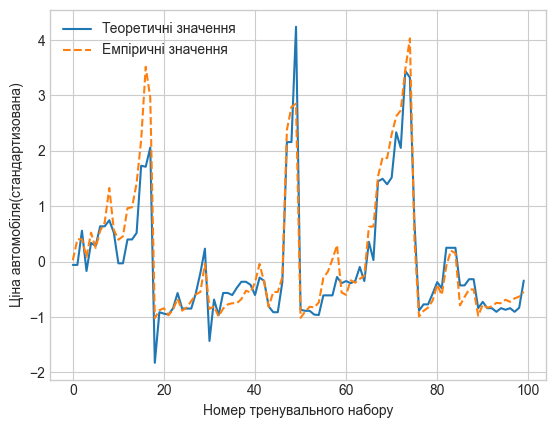

<Figure size 640x480 with 0 Axes>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.style.use('seaborn-v0_8-whitegrid')

data = pd.read_csv('CarPrice_Assignment.csv')
Data = data.drop(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber','carbody','drivewheel',
                  'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'highwaympg', 'curbweight'], 
                   axis=1)



res = normal_data(Data)
y = res['price']
X = res.iloc[:, :-1]


def find_mean(data):
    result = np.sum(data, axis=0)/len(data)
    return result

def find_std(data, ax=0):
    res = data - find_mean(data)
    result = np.sqrt(np.sum(res**2, axis=ax)/len(data))
    return result

def MinMax_norm(data):
    result = (data - data.min())/(data.max() - data.min())
    return result

def normal_data(data):
    result = (data - find_mean(data))/find_std(data)
    return result

def find_covariation(data):
    result = np.zeros((len(data.columns), len(data.columns)))
    for row, i in enumerate(data.columns):
        for col, j  in enumerate(data.columns):
            mean1, mean2 = find_mean(data[i]), find_mean(data[j])
            data1, data2 = data[i]-mean1, data[j]-mean2
            result[row, col] = find_mean(data1 * data2)
    return result    


def find_correlation(data):
    result = find_covariation(data)
    for row, i in enumerate(data.columns):
        for col, j  in enumerate(data.columns):
            mean1, mean2 = find_mean(data[i]), find_mean(data[j])
            std1, std2 = (data[i]-mean1)**2, (data[j]-mean2)**2
            result[row, col] /= np.sqrt(find_mean(std1) * find_mean(std2))
    return result

def build_correlation_df(data):
    cor = find_correlation(data)
    df = pd.DataFrame(cor, columns=data.columns, index=data.columns)
    return df




def prepare_matrix(data, target):
    data = data.copy()
    data.insert(0, 'coef', 1)
    return data.values, target.values


def find_coef(data, target):
    data = prepare_matrix(data, target)
    result = np.linalg.inv(data[0].T @ data[0]) @ data[0].T @ data[1]
    return result


def calculate_theor_result(data, target):
    coef = find_coef(data, target)
    result = []
    for i in range(len(data)):
        result.append(coef[0] + data.iloc[i] @ coef[1:])
    return np.array(result)

def mean_relative_error(data, target):
    theor_r = calculate_theor_result(data, target)
    u = data_y - theor_r
    result = sum(u/data_y * 100)/len(data)
    return result

def RMS_variance_error(data, target):
    theor_r = calculate_theor_result(data, target)
    u = data_y - theor_r
    result = np.sqrt(sum(u**2)/(data.shape[0] - data.shape[1] - 1))
    return result

def res_stand_er(data, target):
    theor_r = calculate_theor_result(data, target)
    n = data.shape[0]
    p = len(find_coef(data, target))
    
    result = np.sqrt(sum((target - theor_r)**2)/(n - p))
    return result



def find_R_sqr(data, target):
    theor_r = calculate_theor_result(data, target)
    SSR = sum((theor_r - find_mean(target))**2)
    SSE = sum(((target - theor_r)**2))
    R_sq = SSR/(SSE + SSR) # 1-SSE/SST
    return R_sq

def find_adj_R_sqr(data, target):
    n = data.shape[0]
    p = len(find_coef(data, target))
    
    R_sqr = find_R_sqr(data, target)
    result = 1 - (1 - R_sqr)*(n - 1)/(n - p)
    return result

def find_F_stat(data, target, sl=0.05):
    R = find_R_sqr(data, target)
    theor_r = calculate_theor_result(data, target)

    n = data.shape[0]
    p = len(find_coef(data, target))
    
    result =  R * (n - p)/((1 - R) * (p - 1))
    
    #find F critical value
    # significance level is 0.05
    F = stats.f.ppf(1-sl, n - p - 1, n)
    if result > F:
        print("Null hypothesis is rejected so coeficients doesn't equal to zero")
    return result, F



def print_formula(data, target):
    coef = find_coef(data, target)
    
    zip_list = [(i,j) for i, j in zip(coef[1:], range(1, len(coef)))]
    res = [inner for outer in zip_list for inner in outer]

    string = ('+ {:4f}*x{} '* (len(coef)-1)).format(*res)
    print(('Y = {:3f} ' + string).format(*coef))
    return None


def build_plots(data, target):
    t_result = calculate_theor_result(data, target)
    fig, ax = plt.subplots()
    ax.plot(t_result[:100], label='Теорeтичні значення')
    ax.plot(target[:100], '--',label='Емпіричні значення')
    plt.xlabel('Номер тренувального набору')
    plt.ylabel('Ціна автомобіля(стандартизована)')
    plt.legend()
    plt.show()
def calc(data, target, coef):
    result = []
    for i in range(len(data)):
        result.append(coef[0] + data.iloc[i] @ coef[1:])
    return np.array(result)



vif = pd.DataFrame()
vif["features"] = X.columns
vif["vif_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(build_correlation_df(res))

print(vif)

print('Coefficients:')
print(find_coef(X, y))
print('Regression folmula: ')
print_formula(X, y)
print('\nCoefficient of determination:\n', find_R_sqr(X, y))
print('\nAdjusted coefficient of determination:\n', find_adj_R_sqr(X, y))
print('\nF-statistic:\n' ,find_F_stat(X, y)[0])
print('F critical:\n' ,find_F_stat(X, y)[1])
build_plots(X, y)
plt.savefig('Regression test data')
plt.show()
